In [27]:
import numpy as np
import pickle as pkl
import h5py
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import matplotlib.patches as patches
import os
import sys
sys.path.append('/home/sofiagil/tfm/LM_V1_Billeh_model_sofia/Model_utils/')
import other_billeh_utils
import sklearn
import skimage

# Load model
cache_path = '/home/sofiagil/tfm/LM_V1_Billeh_model_sofia/Model_utils/.cache/lm_v1_network_v1_100000_lm_30000.pkl'
with open(cache_path, 'rb') as f:
    networks, lgn_inputs, bkg_inputs = pkl.load(f)

In [28]:
n_trials = 50
radius_array = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50] 
n_radius = len(radius_array)
n_neurons_v1 = 51978
n_neurons_lm = 7414
# Define the time bins 250 ms stim len
time_bins = np.array([[100, 350], [450, 700], [800, 1050], [1150, 1400]])
n_timesteps = (time_bins[0,1] - time_bins[0,0]) + (time_bins[1,1] - time_bins[1,0]) + (time_bins[2,1] - time_bins[2,0]) + (time_bins[3,1] - time_bins[3,0])
print("time-steps of stimulus", n_timesteps)

time-steps of stimulus 1000


In [29]:
# Compute neuron's locations
# in networks['v1'] 'x' and 'z' are the 2 radial coordinates, and y is the depth in the column which I don't need
v1_positions_x = np.array(networks['v1']['x'])
v1_positions_z = np.array(networks['v1']['z'])

# filter only core neurons that follow r = np.sqrt(x ** 2 + z ** 2) < 400
r = np.sqrt(v1_positions_x ** 2 + v1_positions_z ** 2)
selected_mask = r < 400
v1_positions_x_core = v1_positions_x[selected_mask]
v1_positions_z_core = v1_positions_z[selected_mask]

# obtain an array with all neurons positions
neurons_positions = np.zeros((n_neurons_v1, 2))
for id in range(n_neurons_v1):
    neuron_pos = v1_positions_x_core[id], v1_positions_z_core[id]
    neuron_pos = ((neuron_pos[0]/1000 * 70/10)+6.5, (neuron_pos[1]/1000 * 40/10)+5.5) # neuron projection to visual space
    neurons_positions[id] = neuron_pos

In [30]:
# load receptive fields
with open('Data_connected/v1_sums.pkl', 'rb') as f:
    v1_sums_rf = pkl.load(f)

with open('Data_connected/lm_sums.pkl', 'rb') as f:
    lm_sums_rf = pkl.load(f)

with open('Data_disconnected/v1_sums.pkl', 'rb') as f:
    v1_sums_dis_rf = pkl.load(f)

# load inverse indices
with open('Data_connected/inverse_indices_v1.pkl', 'rb') as f:
    inverse_indices_v1 = pkl.load(f)

with open('Data_connected/inverse_indices_lm.pkl', 'rb') as f:
    inverse_indices_lm = pkl.load(f)

with open('Data_disconnected/inverse_indices_v1_dis.pkl', 'rb') as f:
    inverse_indices_v1_dis = pkl.load(f)

# load rf areas
with open('Data_connected/rf_areas_v1.pkl', 'rb') as f:
    rf_areas_v1 = pkl.load(f)

# with open('rf_areas_lm.pkl', 'rb') as f:
#     rf_areas_lm = pkl.load(f)

with open('Data_disconnected/rf_areas_v1_dis.pkl', 'rb') as f:
    rf_areas_v1_dis = pkl.load(f)

In [31]:
# Load masks
# Filters for selecting only the excitatory neurons and having them classified in layers
# networks['v1'].keys() to visualize the keys of the dictionary

# obtain the neuron type of each neuron 
new_pop_names = other_billeh_utils.pop_names(networks['v1'], n_selected_neurons=51978, data_dir='/home/sofiagil/tfm/LM_V1_Billeh_model_sofia/GLIF_network')
cell_types_v1 = [other_billeh_utils.pop_name_to_cell_type(pop_name) for pop_name in new_pop_names]

new_pop_names = other_billeh_utils.pop_names(networks['lm'], n_selected_neurons=7414, data_dir='/home/sofiagil/tfm/LM_V1_Billeh_model_sofia/GLIF_network')
cell_types_lm = [other_billeh_utils.pop_name_to_cell_type(pop_name) for pop_name in new_pop_names]

cell_types = [cell_types_v1, cell_types_lm]

unique_cell_types = list(set(cell_types_v1))
unique_cell_types = sorted(unique_cell_types)

# Do a mask for exc. + inh. for each layer of each region
layer_mask_v1 = [[cell_type.startswith(f'L{i}') for cell_type in cell_types[0]] for i in ["1","2/3","4","5","6"]]
layer_mask_lm = [[cell_type.startswith(f'L{i}') for cell_type in cell_types[1]] for i in ["1","2/3","4","5","6"]]

# Do a mask for neuron types in each layer of each region 
# The unique neuron types are stored in unique_cell_types
layer_mask_v1_types = [[cell_type == unique_cell_types[i] for cell_type in cell_types[0]] for i in range(len(unique_cell_types))]
layer_mask_lm_types = [[cell_type == unique_cell_types[i] for cell_type in cell_types[1]] for i in range(len(unique_cell_types))]

# 1. Load the data

## From inverse stimuli

In [8]:
# define some parameters
n_trials = 50
radius_array = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50] 
n_radius = len(radius_array)
n_neurons_v1 = 51978
n_neurons_lm = 7414
# Define the time bins 250 ms stim len
time_bins = np.array([[100, 350], [450, 700], [800, 1050], [1150, 1400]])
n_timesteps = (time_bins[0,1] - time_bins[0,0]) + (time_bins[1,1] - time_bins[1,0]) + (time_bins[2,1] - time_bins[2,0]) + (time_bins[3,1] - time_bins[3,0])
print("time-steps of stimulus", n_timesteps)
v1_sums = np.zeros((n_radius, n_neurons_v1)) # sum of all spikes per neuron and radius
lm_all = np.zeros((n_radius, n_neurons_lm)) # sum of all spikes per neuron and radius

for i, rad in tqdm(enumerate(radius_array)):
        data_file = 'size_tuning_connected_inverse/simulation_data_row_'+str(6)+'_col_'+str(5)+'_r'+str(rad)+'.hdf5'

        # Open the file in read mode
        file = h5py.File(data_file, 'r')

        # Access the 'Data' group
        data_group = file['Data']

        data = {}

        # Loop over the subgroups ('v1', 'lm', 'LGN')
        for subgroup_name in data_group.keys():
            # Access the subgroup
            subgroup = data_group[subgroup_name]
            
            # Access the 'z' dataset in the subgroup
            name = str(6)+'_'+str(5)
            dataset = subgroup[name] 
            
            # Convert the dataset to a numpy array and store it in the dictionary
            data[subgroup_name] = np.array(dataset)

        # Close the file
        file.close()

        v1 = data['v1']
        lm = data['lm']
        LGN = data['LGN']

        for time_bin in time_bins:
            v1_sums[i, :] += np.sum(v1[:, time_bin[0]:time_bin[1]], axis=(0,1))
            lm_all[i, :] += np.sum(lm[:, time_bin[0]:time_bin[1]], axis=(0,1))

# save the data
with open('size_tuning_connected_inverse/v1_sums.pkl', 'wb') as f:
    pkl.dump(v1_sums, f)

with open('size_tuning_connected_inverse/lm_sums.pkl', 'wb') as f:
    pkl.dump(lm_all, f)

print('Data saved')

time-steps of stimulus 1000


10it [02:46, 16.65s/it]

Data saved


In [9]:
# define some parameters
n_trials = 50
radius_array = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50] 
n_radius = len(radius_array)
n_neurons_v1 = 51978
n_neurons_lm = 7414
# Define the time bins 250 ms stim len
time_bins = np.array([[100, 350], [450, 700], [800, 1050], [1150, 1400]])
n_timesteps = (time_bins[0,1] - time_bins[0,0]) + (time_bins[1,1] - time_bins[1,0]) + (time_bins[2,1] - time_bins[2,0]) + (time_bins[3,1] - time_bins[3,0])
print("time-steps of stimulus", n_timesteps)
v1_sums = np.zeros((n_radius, n_neurons_v1)) # sum of all spikes per neuron and radius
lm_all = np.zeros((n_radius, n_neurons_lm)) # sum of all spikes per neuron and radius

for i, rad in tqdm(enumerate(radius_array)):
        data_file = 'size_tuning_disconnected_inverse/simulation_data_row_'+str(6)+'_col_'+str(5)+'_r'+str(rad)+'.hdf5'

        # Open the file in read mode
        file = h5py.File(data_file, 'r')

        # Access the 'Data' group
        data_group = file['Data']

        data = {}

        # Loop over the subgroups ('v1', 'lm', 'LGN')
        for subgroup_name in data_group.keys():
            # Access the subgroup
            subgroup = data_group[subgroup_name]
            
            # Access the 'z' dataset in the subgroup
            name = str(6)+'_'+str(5)
            dataset = subgroup[name] 
            
            # Convert the dataset to a numpy array and store it in the dictionary
            data[subgroup_name] = np.array(dataset)

        # Close the file
        file.close()

        v1 = data['v1']
        lm = data['lm']
        LGN = data['LGN']

        for time_bin in time_bins:
            v1_sums[i, :] += np.sum(v1[:, time_bin[0]:time_bin[1]], axis=(0,1))
            lm_all[i, :] += np.sum(lm[:, time_bin[0]:time_bin[1]], axis=(0,1))

# save the data
with open('size_tuning_disconnected_inverse/v1_sums.pkl', 'wb') as f:
    pkl.dump(v1_sums, f)

with open('size_tuning_disconnected_inverse/lm_sums.pkl', 'wb') as f:
    pkl.dump(lm_all, f)

print('Data saved')

time-steps of stimulus 1000


10it [02:30, 15.02s/it]

Data saved


## From classical stimuli

In [10]:
# define some parameters
n_trials = 50
radius_array = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50] 
n_radius = len(radius_array)
n_neurons_v1 = 51978
n_neurons_lm = 7414
# Define the time bins 250 ms stim len
time_bins = np.array([[100, 350], [450, 700], [800, 1050], [1150, 1400]])
n_timesteps = (time_bins[0,1] - time_bins[0,0]) + (time_bins[1,1] - time_bins[1,0]) + (time_bins[2,1] - time_bins[2,0]) + (time_bins[3,1] - time_bins[3,0])
print("time-steps of stimulus", n_timesteps)
v1_sums = np.zeros((n_radius, n_neurons_v1)) # sum of all spikes per neuron and radius
lm_all = np.zeros((n_radius, n_neurons_lm)) # sum of all spikes per neuron and radius

for i, rad in tqdm(enumerate(radius_array)):
        data_file = 'size_tuning_connected_classical/simulation_data_row_'+str(6)+'_col_'+str(5)+'_r'+str(rad)+'.hdf5'

        # Open the file in read mode
        file = h5py.File(data_file, 'r')

        # Access the 'Data' group
        data_group = file['Data']

        data = {}

        # Loop over the subgroups ('v1', 'lm', 'LGN')
        for subgroup_name in data_group.keys():
            # Access the subgroup
            subgroup = data_group[subgroup_name]
            
            # Access the 'z' dataset in the subgroup
            name = str(6)+'_'+str(5)
            dataset = subgroup[name] 
            
            # Convert the dataset to a numpy array and store it in the dictionary
            data[subgroup_name] = np.array(dataset)

        # Close the file
        file.close()

        v1 = data['v1']
        lm = data['lm']
        LGN = data['LGN']

        for time_bin in time_bins:
            v1_sums[i, :] += np.sum(v1[:, time_bin[0]:time_bin[1]], axis=(0,1))
            lm_all[i, :] += np.sum(lm[:, time_bin[0]:time_bin[1]], axis=(0,1))

# save the data
with open('size_tuning_connected_classical/v1_sums.pkl', 'wb') as f:
    pkl.dump(v1_sums, f)

with open('size_tuning_connected_classical/lm_sums.pkl', 'wb') as f:
    pkl.dump(lm_all, f)

print('Data saved')

time-steps of stimulus 1000


10it [02:27, 14.74s/it]

Data saved


In [11]:
# define some parameters
n_trials = 50
radius_array = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50] 
n_radius = len(radius_array)
n_neurons_v1 = 51978
n_neurons_lm = 7414
# Define the time bins 250 ms stim len
time_bins = np.array([[100, 350], [450, 700], [800, 1050], [1150, 1400]])
n_timesteps = (time_bins[0,1] - time_bins[0,0]) + (time_bins[1,1] - time_bins[1,0]) + (time_bins[2,1] - time_bins[2,0]) + (time_bins[3,1] - time_bins[3,0])
print("time-steps of stimulus", n_timesteps)
v1_sums = np.zeros((n_radius, n_neurons_v1)) # sum of all spikes per neuron and radius
lm_all = np.zeros((n_radius, n_neurons_lm)) # sum of all spikes per neuron and radius

for i, rad in tqdm(enumerate(radius_array)):
        data_file = 'size_tuning_disconnected_classical/simulation_data_row_'+str(6)+'_col_'+str(5)+'_r'+str(rad)+'.hdf5'

        # Open the file in read mode
        file = h5py.File(data_file, 'r')

        # Access the 'Data' group
        data_group = file['Data']

        data = {}

        # Loop over the subgroups ('v1', 'lm', 'LGN')
        for subgroup_name in data_group.keys():
            # Access the subgroup
            subgroup = data_group[subgroup_name]
            
            # Access the 'z' dataset in the subgroup
            name = str(6)+'_'+str(5)
            dataset = subgroup[name] 
            
            # Convert the dataset to a numpy array and store it in the dictionary
            data[subgroup_name] = np.array(dataset)

        # Close the file
        file.close()

        v1 = data['v1']
        lm = data['lm']
        LGN = data['LGN']

        for time_bin in time_bins:
            v1_sums[i, :] += np.sum(v1[:, time_bin[0]:time_bin[1]], axis=(0,1))
            lm_all[i, :] += np.sum(lm[:, time_bin[0]:time_bin[1]], axis=(0,1))

# save the data
with open('size_tuning_disconnected_classical/v1_sums.pkl', 'wb') as f:
    pkl.dump(v1_sums, f)

with open('size_tuning_disconnected_classical/lm_sums.pkl', 'wb') as f:
    pkl.dump(lm_all, f)

print('Data saved')

time-steps of stimulus 1000


10it [02:29, 14.97s/it]

Data saved


# 2. Select significant RF neurons

In [32]:
# Load significant indices:
with open('significant_neurons_v1.pkl', 'rb') as f:
    significant_indices_v1 = pkl.load(f)

with open('significant_neurons_lm.pkl', 'rb') as f:
    significant_indices_lm = pkl.load(f)

# with open('RF_significant_indices_v1_dis.pkl', 'rb') as f:
#      significant_indices_v1_dis = pkl.load(f)

# load baseline rate of every neuron
with open('baseline_rate_neurons_v1_white.pkl', 'rb') as f:
    baseline_rate_v1 = pkl.load(f)

with open('baseline_rate_neurons_v1_dis_white.pkl', 'rb') as f:
    baseline_rate_v1_dis = pkl.load(f)

In [33]:
# Load the data
with open('size_tuning_connected_inverse/v1_sums.pkl', 'rb') as f:
    v1_sums_inv_con = pkl.load(f)

with open('size_tuning_connected_inverse/lm_sums.pkl', 'rb') as f:
    lm_all_inv_con = pkl.load(f)

with open('size_tuning_disconnected_inverse/v1_sums.pkl', 'rb') as f:
    v1_sums_inv_dis = pkl.load(f)

v1_sums_inv_con = v1_sums_inv_con / (n_trials * n_timesteps) * 1000
lm_all_inv_con = lm_all_inv_con / (n_trials * n_timesteps) * 1000
v1_sums_inv_dis = v1_sums_inv_dis / (n_trials * n_timesteps) * 1000

with open('size_tuning_connected_classical/v1_sums.pkl', 'rb') as f:
    v1_sums_cla_con = pkl.load(f)

with open('size_tuning_connected_classical/lm_sums.pkl', 'rb') as f:
    lm_all_cla_con = pkl.load(f)

with open('size_tuning_disconnected_classical/v1_sums.pkl', 'rb') as f:
    v1_sums_cla_dis = pkl.load(f)

v1_sums_cla_con = v1_sums_cla_con / (n_trials * n_timesteps) * 1000
lm_all_cla_con = lm_all_cla_con / (n_trials * n_timesteps) * 1000
v1_sums_cla_dis = v1_sums_cla_dis / (n_trials * n_timesteps) * 1000

In [34]:
# Select significant neurons only
v1_sums_inv_con = v1_sums_inv_con[:, significant_indices_v1]
lm_all_inv_con = lm_all_inv_con[:, significant_indices_lm]
v1_sums_cla_con = v1_sums_cla_con[:, significant_indices_v1]
lm_all_cla_con = lm_all_cla_con[:, significant_indices_lm]
v1_sums_inv_dis = v1_sums_inv_dis[:, significant_indices_v1]
v1_sums_cla_dis = v1_sums_cla_dis[:, significant_indices_v1]

# update number of v1 and lm neurons
n_neurons_v1 = len(significant_indices_v1)
n_neurons_lm = len(significant_indices_lm)
# n_neurons_v1_dis = len(significant_indices_v1_dis)

# select also in the baseline firing rates
baseline_rate_v1 = np.array(baseline_rate_v1)
baseline_rate_v1_dis = np.array(baseline_rate_v1_dis)

baseline_rate_v1 = baseline_rate_v1[significant_indices_v1]
baseline_rate_v1_dis = baseline_rate_v1_dis[significant_indices_v1]

In [35]:
# Remove them also from the layer masks
# convert masks to arrays
layer_mask_v1 = np.array(layer_mask_v1)
layer_mask_lm = np.array(layer_mask_lm)

layer_mask_v1_rf = np.array([layer_mask_v1[:, i] for i in range(layer_mask_v1.shape[1]) if i in significant_indices_v1]).T
layer_mask_lm_rf = np.array([layer_mask_lm[:, i] for i in range(layer_mask_lm.shape[1]) if i in significant_indices_lm]).T
layer_mask_v1_dis_rf = np.array([layer_mask_v1[:, i] for i in range(layer_mask_v1.shape[1]) if i in significant_indices_v1]).T

# do it also for neuron types masks
layer_mask_v1_types = np.array(layer_mask_v1_types)
layer_mask_lm_types = np.array(layer_mask_lm_types)

layer_mask_v1_types_rf = np.array([layer_mask_v1_types[:, i] for i in range(layer_mask_v1_types.shape[1]) if i in significant_indices_v1]).T
layer_mask_lm_types_rf = np.array([layer_mask_lm_types[:, i] for i in range(layer_mask_lm_types.shape[1]) if i in significant_indices_lm]).T
layer_mask_v1_dis_rf = np.array([layer_mask_v1_types[:, i] for i in range(layer_mask_v1_types.shape[1]) if i in significant_indices_v1]).T

In [36]:
# Remove also from the receptive fields
v1_sums_rf = np.array(v1_sums_rf)
lm_sums_rf = np.array(lm_sums_rf)
v1_sums_dis_rf = np.array(v1_sums_dis_rf)

v1_sums_rf = v1_sums_rf[:,:, significant_indices_v1]
lm_sums_rf = lm_sums_rf[:,:, significant_indices_lm]
v1_sums_dis_rf = v1_sums_dis_rf[:,:, significant_indices_v1]

# and from the areas
rf_areas_v1 = np.array(rf_areas_v1)
# rf_areas_lm = np.array(rf_areas_lm)
rf_areas_v1_dis = np.array(rf_areas_v1_dis)

rf_areas_v1 = rf_areas_v1[significant_indices_v1]
# rf_areas_lm = rf_areas_lm[significant_indices_lm]
rf_areas_v1_dis = rf_areas_v1_dis[significant_indices_v1]

In [37]:
# Remove also from neuron's positions
neurons_positions = neurons_positions[significant_indices_v1]

# 3. Plot size tunning curve for individual neurons

In [38]:
# substract to each neuron its baseline firing rate
v1_sums_inv_con = v1_sums_inv_con - baseline_rate_v1
v1_sums_cla_con = v1_sums_cla_con - baseline_rate_v1
v1_sums_inv_dis = v1_sums_inv_dis - baseline_rate_v1_dis
v1_sums_cla_dis = v1_sums_cla_dis - baseline_rate_v1_dis

In [39]:
# normalize size tunning functions for each neuron with respect to the maximum response (TO CLASSICAL OR INVERSE)

max_inv_cla = np.maximum(np.max(np.abs(v1_sums_inv_con), axis=0), np.max(np.abs(v1_sums_cla_con), axis=0))
v1_sums_inv_con = v1_sums_inv_con / max_inv_cla
v1_sums_cla_con = v1_sums_cla_con / max_inv_cla

max_inv_dis = np.maximum(np.max(np.abs(v1_sums_inv_dis), axis=0), np.max(np.abs(v1_sums_cla_dis), axis=0))
v1_sums_inv_dis = v1_sums_inv_dis / max_inv_dis
v1_sums_cla_dis = v1_sums_cla_dis / max_inv_dis

max_inv_cla_lm = np.maximum(np.max(np.abs(lm_all_inv_con), axis=0), np.max(np.abs(lm_all_cla_con), axis=0))
lm_all_inv_con = lm_all_inv_con / max_inv_cla_lm
lm_all_cla_con = lm_all_cla_con / max_inv_cla_lm


L5 Exc
RF area 200.0


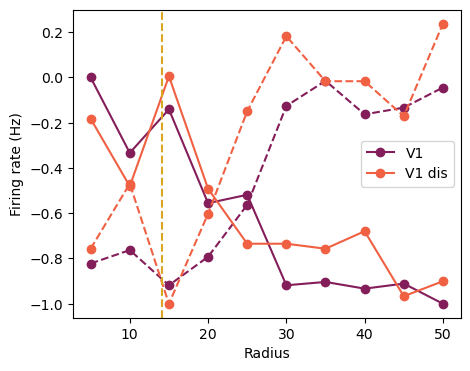

neurons position [7.90033987 5.62316685]


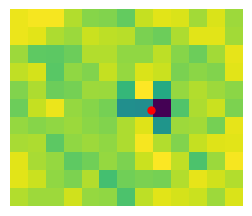

In [40]:
# Select the neuron
# inverse: 11
# Select 5 colors from the 'deep' palette
color = sns.color_palette("rocket", 5)

neuron_idx = 1
v1_neuron_inv = v1_sums_inv_con[:, neuron_idx]
v1_neuron_cla = v1_sums_cla_con[:, neuron_idx]
v1_neuron_inv_dis = v1_sums_inv_dis[:, neuron_idx]
v1_neuron_cla_dis = v1_sums_cla_dis[:, neuron_idx]
# lm_neuron_inv = lm_all_inv_con[:, neuron_idx]
# lm_neuron_cla = lm_all_cla_con[:, neuron_idx]

# print the type of the neuron
print(cell_types_v1[neuron_idx])

# Plot the size tunning function
plt.figure(figsize=(5, 4))
plt.plot(radius_array, v1_neuron_inv, 'o--', color = color[1])
plt.plot(radius_array, v1_neuron_cla, 'o-', color = color[1], label = "V1")
plt.plot(radius_array, v1_neuron_inv_dis, 'o--',  color = color[3])
plt.plot(radius_array, v1_neuron_cla_dis, 'o-', color = color[3], label = "V1 dis")
# plt.plot(radius_array, lm_neuron_inv, 'o--', label='Inverse stimuli', color = color[1])
# plt.plot(radius_array, lm_neuron_cla, 'o-', label='Classical stimuli', color = color[1])
plt.xlabel('Radius')
plt.ylabel('Firing rate (Hz)')
plt.legend()
# print the rf area of the neuron
print('RF area', rf_areas_v1[neuron_idx])

# compute the radius corresponding to the area
rf_area = rf_areas_v1[neuron_idx]
rf_radius = np.sqrt(rf_area)

# plot as a vertical line
plt.axvline(x=rf_radius, color='goldenrod', linestyle='--')
plt.show()

# plot its receptive field as a heatmap
plt.figure(figsize=(3, 3))
ax = sns.heatmap(v1_sums_rf[:,:,neuron_idx].T, cmap='viridis', cbar_kws={'label': 'Average firing rate (Hz)'}, square = True, cbar = False)
# ax = sns.heatmap(lm_sums_rf[:,:,neuron_idx].T, cmap='viridis', cbar_kws={'label': 'Average firing rate (Hz)'}, square = True, cbar = False)
plt.axis('off')

# plot the neuron position	
neuron_pos = neurons_positions[neuron_idx]
plt.plot(neuron_pos[0], neuron_pos[1], 'ro', markersize = 5)
print('neuron''s position', neuron_pos)

# 4. Select neurons only with with projection centered

In [41]:
# Create mask of neurons with position with 6<x<7 and 5<y<6
centered_mask = (neurons_positions[:,0] > 6) & (neurons_positions[:,0] < 7) & (neurons_positions[:,1] > 5) & (neurons_positions[:,1] < 6)

# print the percentage of neurons that are in the mask
print('Percentage of centered neurons', np.sum(centered_mask)/len(centered_mask)*100)
print('Number of centered neurons', np.sum(centered_mask))

#get the neurons in the center of each layer
centered_mask_l1 = centered_mask & layer_mask_v1_rf[0]
# print the number of neurons in the center of layer 1
print('Number of neurons in the center of L1:', np.sum(centered_mask_l1))

centered_mask_l23 = centered_mask & layer_mask_v1_rf[1]
# print the number of neurons in the center of layer 2
print('Number of neurons in the center of L2/3:', np.sum(centered_mask_l23))

centered_mask_l4 = centered_mask & layer_mask_v1_rf[2]
# print the number of neurons in the center of layer 4
print('Number of neurons in the center of L4:', np.sum(centered_mask_l4))

centered_mask_l5 = centered_mask & layer_mask_v1_rf[3]
# print the number of neurons in the center of layer 5
print('Number of neurons in the center of L5:', np.sum(centered_mask_l5))

centered_mask_l6 = centered_mask & layer_mask_v1_rf[4]
# print the number of neurons in the center of layer 6
print('Number of neurons in the center of L6:', np.sum(centered_mask_l6))

Percentage of centered neurons 5.228248146703082
Number of centered neurons 536
Number of neurons in the center of L1: 23
Number of neurons in the center of L2/3: 48
Number of neurons in the center of L4: 176
Number of neurons in the center of L5: 95
Number of neurons in the center of L6: 194


In [42]:
# Do the same but for neuron type masks
centered_mask_types = np.zeros((len(unique_cell_types), n_neurons_v1), dtype=bool)
for i in range(len(unique_cell_types)):
    centered_mask_types[i] = centered_mask & layer_mask_v1_types_rf[i]

# print the number of neurons in the center of each layer
for i in range(len(unique_cell_types)):
    print('Number of neurons in the center of', unique_cell_types[i], ':', np.sum(centered_mask_types[i]))

Number of neurons in the center of L1 Htr3a : 23
Number of neurons in the center of L2/3 Exc : 5
Number of neurons in the center of L2/3 Htr3a : 24
Number of neurons in the center of L2/3 PV : 9
Number of neurons in the center of L2/3 SST : 10
Number of neurons in the center of L4 Exc : 98
Number of neurons in the center of L4 Htr3a : 0
Number of neurons in the center of L4 PV : 45
Number of neurons in the center of L4 SST : 33
Number of neurons in the center of L5 Exc : 33
Number of neurons in the center of L5 Htr3a : 1
Number of neurons in the center of L5 PV : 33
Number of neurons in the center of L5 SST : 28
Number of neurons in the center of L6 Exc : 111
Number of neurons in the center of L6 Htr3a : 0
Number of neurons in the center of L6 PV : 33
Number of neurons in the center of L6 SST : 50


In [43]:
# Select those neurons in the size tunning functions for each layer
v1_centered_l1_inv_con = v1_sums_inv_con[:, centered_mask_l1]
v1_centered_l23_inv_con = v1_sums_inv_con[:, centered_mask_l23]
v1_centered_l4_inv_con = v1_sums_inv_con[:, centered_mask_l4]
v1_centered_l5_inv_con = v1_sums_inv_con[:, centered_mask_l5]
v1_centered_l6_inv_con = v1_sums_inv_con[:, centered_mask_l6]

v1_centered_l1_inv_dis = v1_sums_inv_dis[:, centered_mask_l1]
v1_centered_l23_inv_dis = v1_sums_inv_dis[:, centered_mask_l23]
v1_centered_l4_inv_dis = v1_sums_inv_dis[:, centered_mask_l4]
v1_centered_l5_inv_dis = v1_sums_inv_dis[:, centered_mask_l5]
v1_centered_l6_inv_dis = v1_sums_inv_dis[:, centered_mask_l6]

v1_centered_l1_cla_con = v1_sums_cla_con[:, centered_mask_l1]
v1_centered_l23_cla_con = v1_sums_cla_con[:, centered_mask_l23]
v1_centered_l4_cla_con = v1_sums_cla_con[:, centered_mask_l4]
v1_centered_l5_cla_con = v1_sums_cla_con[:, centered_mask_l5]
v1_centered_l6_cla_con = v1_sums_cla_con[:, centered_mask_l6]

v1_centered_l1_cla_dis = v1_sums_cla_dis[:, centered_mask_l1]
v1_centered_l23_cla_dis = v1_sums_cla_dis[:, centered_mask_l23]
v1_centered_l4_cla_dis = v1_sums_cla_dis[:, centered_mask_l4]
v1_centered_l5_cla_dis = v1_sums_cla_dis[:, centered_mask_l5]
v1_centered_l6_cla_dis = v1_sums_cla_dis[:, centered_mask_l6]

# select also their receptive fields by layer
v1_centered_l1_rf = v1_sums_rf[:,:, centered_mask_l1]
v1_centered_l23_rf = v1_sums_rf[:,:, centered_mask_l23]
v1_centered_l4_rf = v1_sums_rf[:,:, centered_mask_l4]
v1_centered_l5_rf = v1_sums_rf[:,:, centered_mask_l5]
v1_centered_l6_rf = v1_sums_rf[:,:, centered_mask_l6]

# do it also for the disconnected model
v1_centered_l1_rf_dis = v1_sums_dis_rf[:,:, centered_mask_l1]
v1_centered_l23_rf_dis = v1_sums_dis_rf[:,:, centered_mask_l23]
v1_centered_l4_rf_dis = v1_sums_dis_rf[:,:, centered_mask_l4]
v1_centered_l5_rf_dis = v1_sums_dis_rf[:,:, centered_mask_l5]
v1_centered_l6_rf_dis = v1_sums_dis_rf[:,:, centered_mask_l6]

# select also the areas
v1_centered_l1_areas = rf_areas_v1[centered_mask_l1]
v1_centered_l23_areas = rf_areas_v1[centered_mask_l23]
v1_centered_l4_areas = rf_areas_v1[centered_mask_l4]
v1_centered_l5_areas = rf_areas_v1[centered_mask_l5]
v1_centered_l6_areas = rf_areas_v1[centered_mask_l6]

In [227]:
# # Select now only by layers without being necessariliy centered
# v1_l1_inv_con = v1_sums_inv_con[:, layer_mask_v1_rf[0]]
# v1_l23_inv_con = v1_sums_inv_con[:, layer_mask_v1_rf[1]]
# v1_l4_inv_con = v1_sums_inv_con[:, layer_mask_v1_rf[2]]
# v1_l5_inv_con = v1_sums_inv_con[:, layer_mask_v1_rf[3]]
# v1_l6_inv_con = v1_sums_inv_con[:, layer_mask_v1_rf[4]]

# v1_l1_cla_con = v1_sums_cla_con[:, layer_mask_v1_rf[0]]
# v1_l23_cla_con = v1_sums_cla_con[:, layer_mask_v1_rf[1]]
# v1_l4_cla_con = v1_sums_cla_con[:, layer_mask_v1_rf[2]]
# v1_l5_cla_con = v1_sums_cla_con[:, layer_mask_v1_rf[3]]
# v1_l6_cla_con = v1_sums_cla_con[:, layer_mask_v1_rf[4]]

# # select also their receptive fields by layer
# v1_l1_rf = v1_sums_rf[:,:, layer_mask_v1_rf[0]]
# v1_l23_rf = v1_sums_rf[:,:, layer_mask_v1_rf[1]]
# v1_l4_rf = v1_sums_rf[:,:, layer_mask_v1_rf[2]]
# v1_l5_rf = v1_sums_rf[:,:, layer_mask_v1_rf[3]]
# v1_l6_rf = v1_sums_rf[:,:, layer_mask_v1_rf[4]]

In [44]:
# do it also for neuron types
v1_centered_types_inv_con = []
v1_centered_types_cla_con = []
v1_centered_types_inv_dis = []
v1_centered_types_cla_dis = []
v1_centered_types_rf = []
v1_centered_types_rf_dis = []
v1_centered_types_areas = []
for i in range(len(unique_cell_types)):
    centered_mask_types_i = centered_mask_types[i]
    v1_centered_types_inv_con.append(v1_sums_inv_con[:, centered_mask_types_i])
    v1_centered_types_cla_con.append(v1_sums_cla_con[:, centered_mask_types_i])
    v1_centered_types_inv_dis.append(v1_sums_inv_dis[:, centered_mask_types_i])
    v1_centered_types_cla_dis.append(v1_sums_cla_dis[:, centered_mask_types_i])

    v1_centered_types_rf.append(v1_sums_rf[:,:, centered_mask_types_i])
    v1_centered_types_rf_dis.append(v1_sums_dis_rf[:,:, centered_mask_types_i])
    v1_centered_types_areas.append(rf_areas_v1[centered_mask_types_i])



# # do it also for neuron types without being centered
# v1_types_inv_con = []
# v1_types_cla_con = []

# v1_types_rf = []
# for i in range(len(unique_cell_types)):
#     layer_mask_v1_types_i = layer_mask_v1_types_rf[i]
#     v1_types_inv_con.append(v1_sums_inv_con[:, layer_mask_v1_types_i])
#     v1_types_cla_con.append(v1_sums_cla_con[:, layer_mask_v1_types_i])
#     v1_types_rf.append(v1_sums_rf[:,:, layer_mask_v1_types_i])



FileNotFoundError: [Errno 2] No such file or directory: 'size_tuning_plots/L2/3 Exc_neuron_0.png'

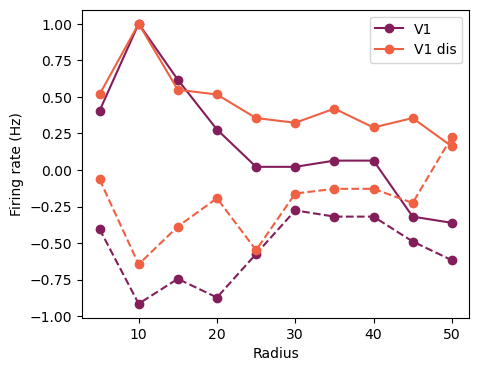

In [45]:
# plot and save (without printing the plot) all the RF of a neuron type with its index inside the given neuron type
# unique_cell_types[1] = 'L23 Exc'
# unique_cell_types[2] = 'L23 Htr3a'
# unique_cell_types[3] = 'L23 Pv'
# unique_cell_types[4] = 'L23 Sst'
# for type in range(1):
#     for idx in range(len(v1_centered_types_rf[type].T)):
#         plt.figure(figsize=(3, 3))
#         ax = sns.heatmap(v1_centered_types_rf[type][:,:,idx].T, cmap='viridis', cbar_kws={'label': 'Average firing rate (Hz)'}, square = True, cbar = False)
#         plt.axis('off')
#         plt.savefig('RFs/'+unique_cell_types[type]+'_neuron_'+str(idx)+'.png')
#         plt.close()

# do the same with size tunning functions
for type in [1]:
    for idx in range(len(v1_centered_types_inv_con[type].T)):
        plt.figure(figsize=(5, 4))
        plt.plot(radius_array, v1_centered_types_inv_con[type][:, idx], 'o--', color = color[1])
        plt.plot(radius_array, v1_centered_types_cla_con[type][:, idx], 'o-', color = color[1], label = "V1")
        plt.plot(radius_array, v1_centered_types_inv_dis[type][:, idx], 'o--',  color = color[3])
        plt.plot(radius_array, v1_centered_types_cla_dis[type][:, idx], 'o-', color = color[3], label = "V1 dis")
        plt.xlabel('Radius')
        plt.ylabel('Firing rate (Hz)')
        plt.legend()
        plt.savefig('size_tuning_plots/'+unique_cell_types[type]+'_neuron_'+str(idx)+'.png')
        plt.close()

L2/3 Exc
RF area 300.0


(0.0, 13.0, 11.0, 0.0)

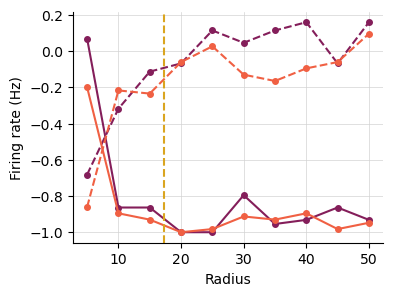

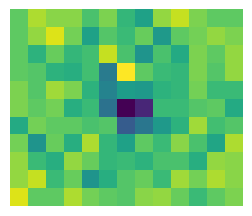

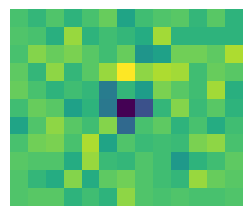

In [53]:
# plot the size tunning functions
idx = 4
type = 1
print(unique_cell_types[type])
plt.figure(figsize=(4, 3))
plt.plot(radius_array, v1_centered_types_inv_con[type][:,idx], 'o--', color=color[1], markersize=4)
plt.plot(radius_array, v1_centered_types_cla_con[type][:,idx], 'o-', color=color[1], markersize=4)
plt.plot(radius_array, v1_centered_types_inv_dis[type][:,idx], 'o--', color=color[3], markersize=4)
plt.plot(radius_array, v1_centered_types_cla_dis[type][:,idx], 'o-', color=color[3], markersize=4)
plt.xlabel('Radius')
plt.ylabel('Firing rate (Hz)')

# plot the sqrt of the RF area
rf_area = v1_centered_types_areas[type][idx]
rf_radius = np.sqrt(rf_area)
plt.axvline(x=rf_radius, color='goldenrod', linestyle='--')
print('RF area', rf_area)

# Add a light grey grid
plt.grid(color='lightgrey', linestyle='-', linewidth=0.5)
# Remove top and right axes
ax = plt.gca()  # gca stands for 'get current axis'
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# # plot the neuron's RF
plt.figure(figsize=(3, 3))
ax = sns.heatmap(v1_centered_types_rf[type][:,:,idx].T, cmap='viridis', cbar_kws={'label': 'Average firing rate (Hz)'}, square=True, cbar=False)
plt.axis('off')

# plot the neuron's disconnected rf
plt.figure(figsize=(3, 3))
ax = sns.heatmap(v1_centered_types_rf_dis[type][:,:,idx].T, cmap='viridis', cbar_kws={'label': 'Average firing rate (Hz)'}, square=True, cbar=False)
plt.axis('off')


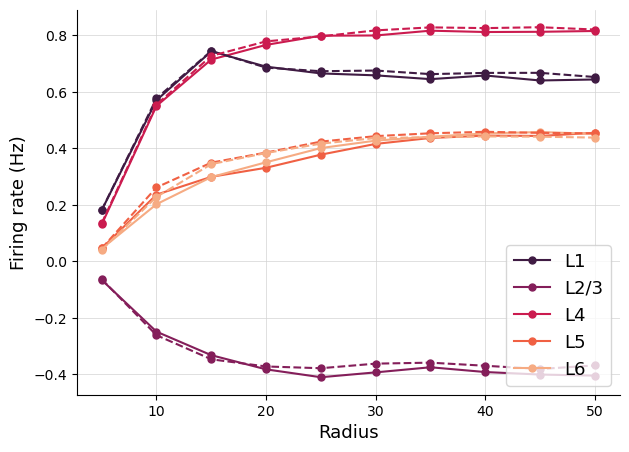

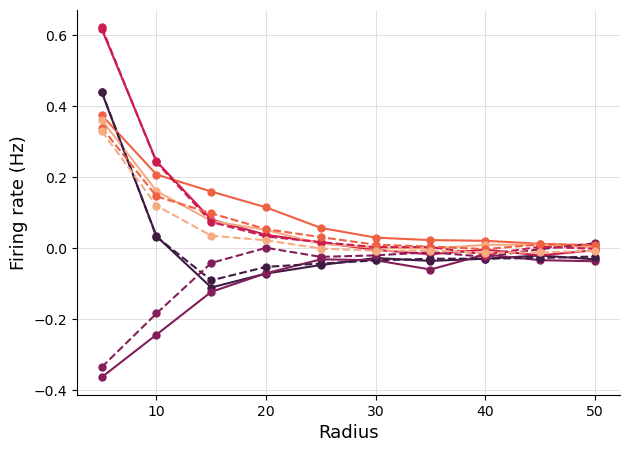

In [54]:
# make some plots
# Select 5 colors from the 'deep' palette
color = sns.color_palette("rocket", 5)

# plot the mean size tunning function for all neurons in the center of each layer
plt.figure(figsize=(7, 5), dpi=100)

plt.plot(radius_array, np.mean(v1_centered_l1_cla_con, axis=1), 'o-', label='L1', color=color[0], markersize=5)
plt.plot(radius_array, np.mean(v1_centered_l23_cla_con, axis=1), 'o-', color=color[1], label='L2/3', markersize=5)
plt.plot(radius_array, np.mean(v1_centered_l4_cla_con, axis=1), 'o-', color=color[2], label='L4', markersize=5)
plt.plot(radius_array, np.mean(v1_centered_l5_cla_con, axis=1), 'o-', color=color[3], label='L5', markersize=5)
plt.plot(radius_array, np.mean(v1_centered_l6_cla_con, axis=1), 'o-', color=color[4], label='L6', markersize=5)

plt.plot(radius_array, np.mean(v1_centered_l1_cla_dis, axis=1), 'o--', color=color[0], markersize=5)
plt.plot(radius_array, np.mean(v1_centered_l23_cla_dis, axis=1), 'o--', color=color[1], markersize=5)
plt.plot(radius_array, np.mean(v1_centered_l4_cla_dis, axis=1), 'o--', color=color[2], markersize=5)
plt.plot(radius_array, np.mean(v1_centered_l5_cla_dis, axis=1), 'o--', color=color[3], markersize=5)
plt.plot(radius_array, np.nanmean(v1_centered_l6_cla_dis, axis=1), 'o--', color=color[4], markersize=5)

plt.xlabel('Radius', fontsize=13)
plt.ylabel('Firing rate (Hz)', fontsize=13)
plt.legend(fontsize=13)
# Add a light grey grid
plt.grid(color='lightgrey', linestyle='-', linewidth=0.5)
# Remove top and right axes
ax = plt.gca()  # gca stands for 'get current axis'
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

plt.figure(figsize=(7, 5), dpi=100)
plt.plot(radius_array, np.mean(v1_centered_l1_inv_con, axis=1), 'o-', color=color[0], markersize=5)
plt.plot(radius_array, np.mean(v1_centered_l23_inv_con, axis=1), 'o-', color=color[1], markersize=5)
plt.plot(radius_array, np.mean(v1_centered_l4_inv_con, axis=1), 'o-', color=color[2], markersize=5)
plt.plot(radius_array, np.mean(v1_centered_l5_inv_con, axis=1), 'o-', color=color[3], markersize=5)
plt.plot(radius_array, np.mean(v1_centered_l6_inv_con, axis=1), 'o-', color=color[4], markersize=5)

plt.plot(radius_array, np.mean(v1_centered_l1_inv_dis, axis=1), 'o--', color=color[0], markersize=5)
plt.plot(radius_array, np.mean(v1_centered_l23_inv_dis, axis=1), 'o--', color=color[1], markersize=5)
plt.plot(radius_array, np.mean(v1_centered_l4_inv_dis, axis=1), 'o--', color=color[2], markersize=5)
plt.plot(radius_array, np.mean(v1_centered_l5_inv_dis, axis=1), 'o--', color=color[3], markersize=5)
plt.plot(radius_array, np.nanmean(v1_centered_l6_inv_dis, axis=1), 'o--', color=color[4], markersize=5)

plt.xlabel('Radius', fontsize=13)
plt.ylabel('Firing rate (Hz)', fontsize=13)
# plt.legend(fontsize=13)
# Add a light grey grid
plt.grid(color='lightgrey', linestyle='-', linewidth=0.5)
# Remove top and right axes
ax = plt.gca()  # gca stands for 'get current axis'
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

### Without centered

In [83]:
# Repeat the same but without the centered filter
# plot the size tunning functions
idx = 0
plt.figure(figsize=(4, 3))
plt.plot(radius_array, v1_l5_inv_con[:,idx], 'o--', color = color[1])
plt.plot(radius_array, v1_l5_cla_con[:,idx], 'o-', color = color[1])
plt.xlabel('Radius')
plt.ylabel('Firing rate (Hz)')

# # plot the neuron's RF
plt.figure(figsize=(3, 3))
ax = sns.heatmap(v1_l5_rf[:,:,idx].T, cmap='viridis', cbar_kws={'label': 'Average firing rate (Hz)'}, square = True, cbar = False)
plt.axis('off')

# Select 5 colors from the 'deep' palette
color = sns.color_palette("rocket", 5)

# plot the mean size tunning function for all neurons in the center of each layer
plt.figure(figsize=(7, 5), dpi = 100)

plt.plot(radius_array, np.mean(v1_l1_cla_con, axis=1), 'o-', label = 'L1', color = color[0])
plt.plot(radius_array, np.mean(v1_l23_cla_con, axis=1), 'o-', color = color[1], label = 'L2/3')
plt.plot(radius_array, np.mean(v1_l4_cla_con, axis=1), 'o-', color = color[2], label = 'L4')
plt.plot(radius_array, np.mean(v1_l5_cla_con, axis=1), 'o-', color = color[3], label = 'L5')
plt.plot(radius_array, np.mean(v1_l6_cla_con, axis=1), 'o-', color = color[4], label = 'L6')

plt.xlabel('Radius', fontsize = 13)
plt.ylabel('Firing rate (Hz)', fontsize = 13)
plt.legend(fontsize = 13)
# Add a light grey grid
plt.grid(color='lightgrey', linestyle='-', linewidth=0.5)
# Remove top and right axes
ax = plt.gca()  # gca stands for 'get current axis'
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

plt.figure(figsize=(7, 5), dpi = 100)
plt.plot(radius_array, np.mean(v1_l1_inv_con, axis=1), 'o--', color = color[0])
plt.plot(radius_array, np.mean(v1_l23_inv_con, axis=1), 'o--', color = color[1])
plt.plot(radius_array, np.mean(v1_l4_inv_con, axis=1), 'o--', color = color[2])
plt.plot(radius_array, np.mean(v1_l5_inv_con, axis=1), 'o--', color = color[3])
plt.plot(radius_array, np.mean(v1_l6_inv_con, axis=1), 'o--', color = color[4])

plt.xlabel('Radius', fontsize = 13)
plt.ylabel('Firing rate (Hz)', fontsize = 13)
plt.legend(fontsize = 13)
# Add a light grey grid
plt.grid(color='lightgrey', linestyle='-', linewidth=0.5)
# Remove top and right axes
ax = plt.gca()  # gca stands for 'get current axis'
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')





NameError: name 'v1_l5_inv_con' is not defined

<Figure size 400x300 with 0 Axes>

## Per neuron types

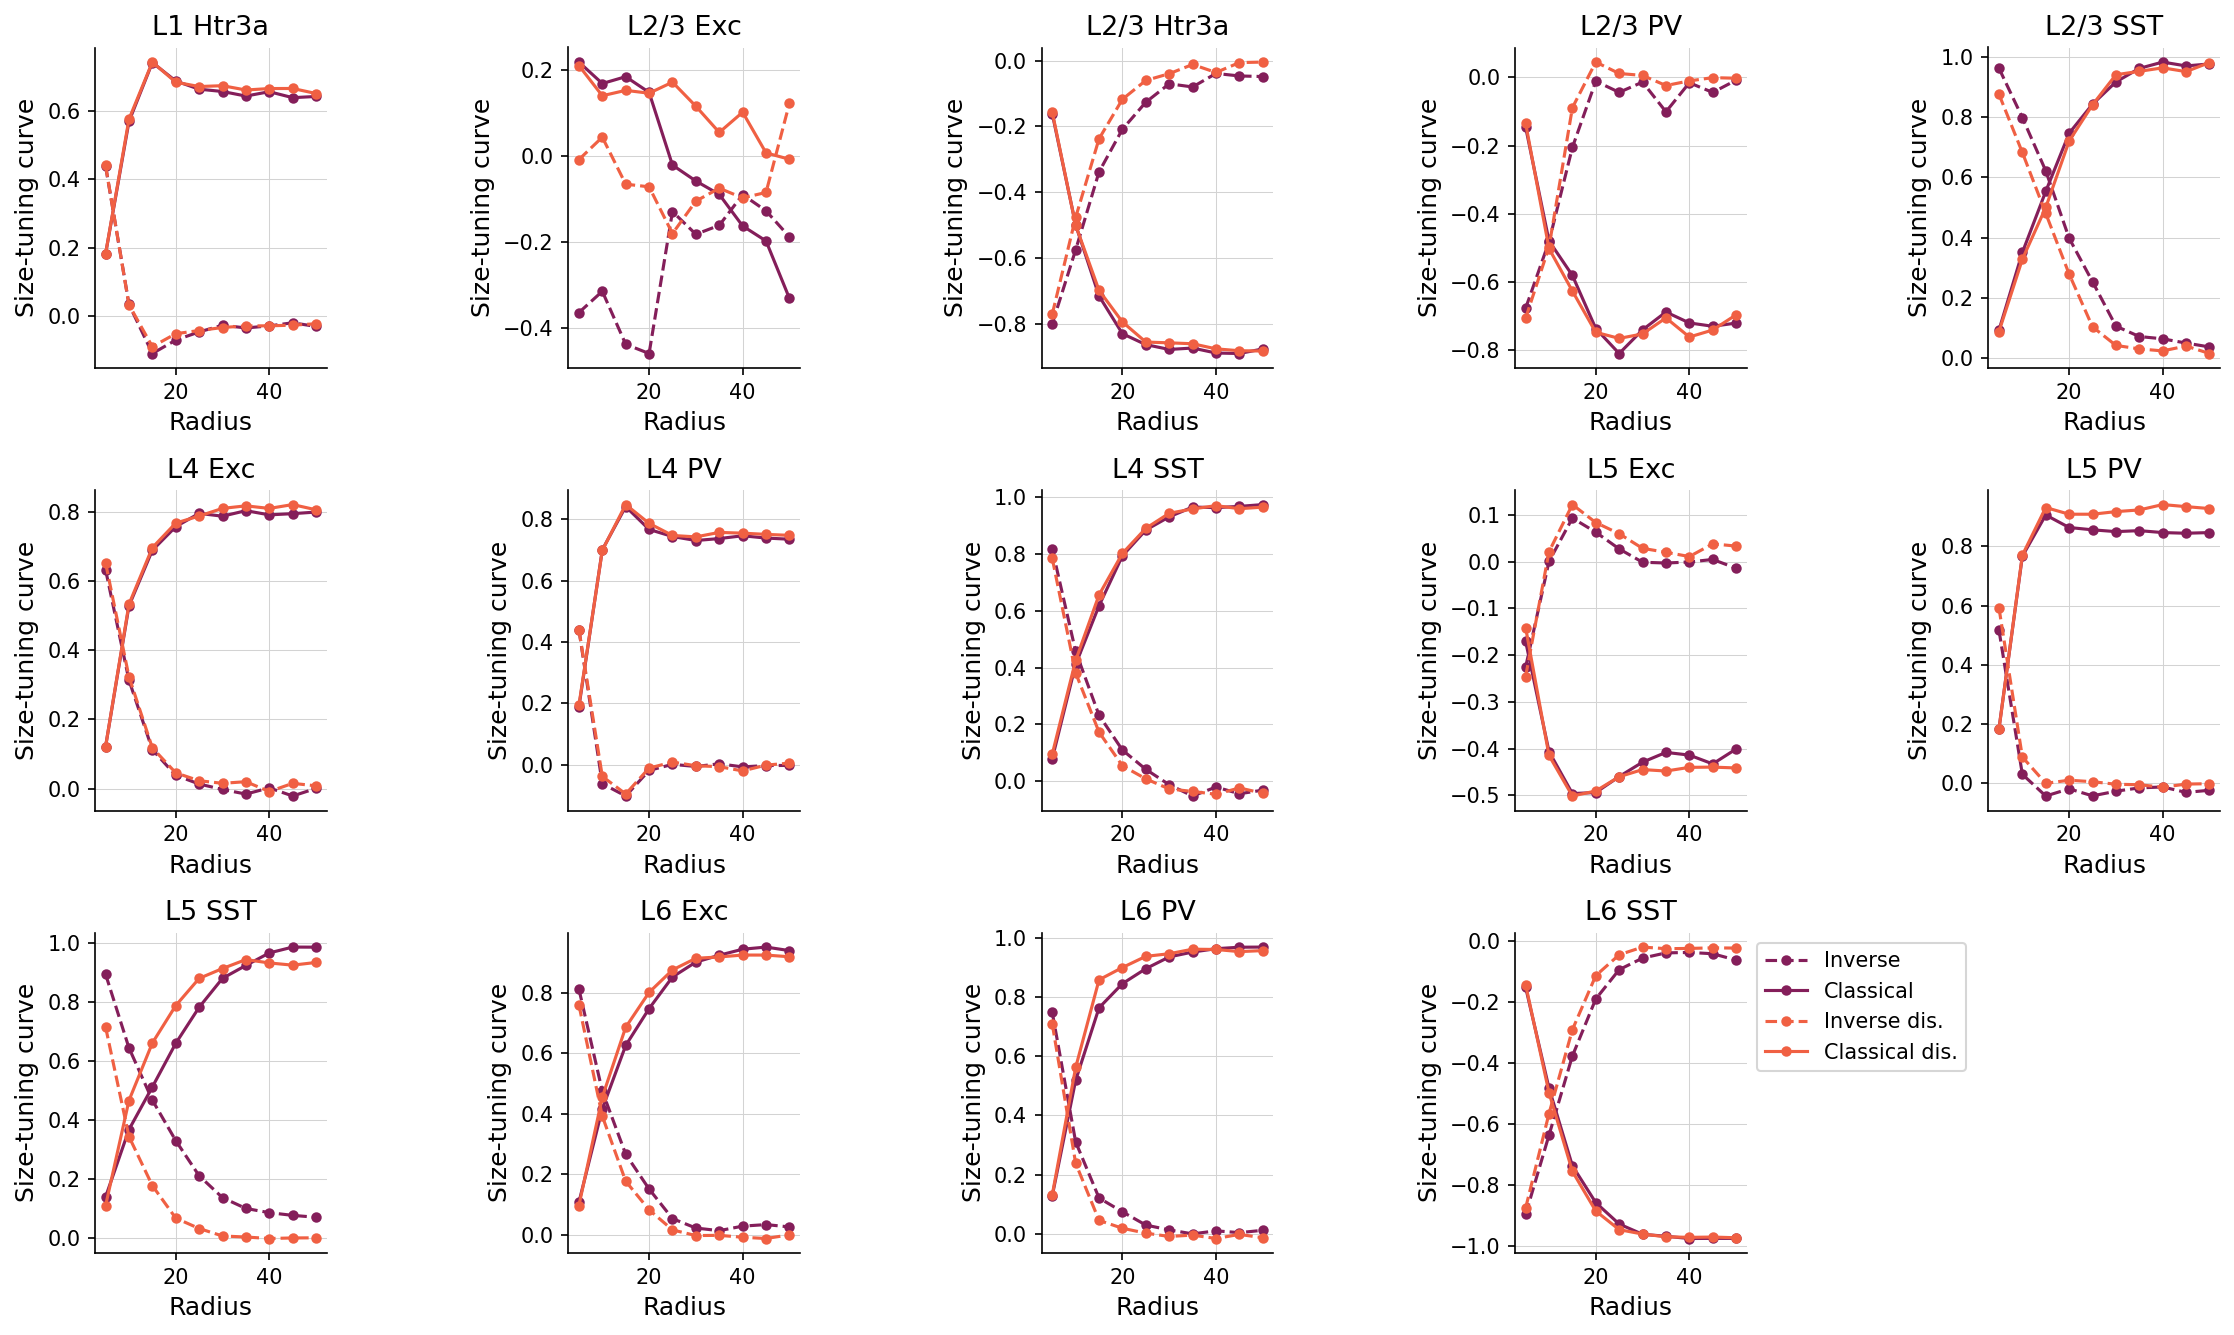

In [55]:
# Set up the subplot grid
fig, axs = plt.subplots(3, 5, figsize=(15, 9), dpi=150, sharex=True)
fig.tight_layout(pad=3.0)

# Indices of subplots to remove (Python uses 0-based indexing, so subtract 1 from each)
remove_indices = [6, 10, 14]  # Adjusted for 0-based indexing

# Generate a list of indices for the subplots we want to keep
subplot_indices = [i for i in range(17) if i not in remove_indices]

# Loop through the list of subplot indices
for new_idx, idx in enumerate(subplot_indices):
    # Calculate new row and column for the subplot
    row = new_idx // 5
    col = new_idx % 5
    ax = axs[row, col]
    
    # Plot data
    ax.plot(radius_array, np.nanmean(v1_centered_types_inv_con[idx], axis=1), 'o--', color=color[1], markersize=4)
    ax.plot(radius_array, np.nanmean(v1_centered_types_cla_con[idx], axis=1), 'o-', color=color[1], markersize=4)
    ax.plot(radius_array, np.nanmean(v1_centered_types_inv_dis[idx], axis=1), 'o--', color=color[3], markersize=4)
    ax.plot(radius_array, np.nanmean(v1_centered_types_cla_dis[idx], axis=1), 'o-', color=color[3], markersize=4)
    ax.set_title(unique_cell_types[idx], fontsize = 13)
    ax.set_xlabel('Radius', fontsize = 12)
    ax.set_ylabel('Size-tuning curve', fontsize = 12)
    
    # Add a light grey grid to each subplot
    ax.grid(color='lightgrey', linestyle='-', linewidth=0.5)
    
    # Remove top and right axes for each subplot
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

# Hide the empty subplots (if any)
for idx in range(len(subplot_indices), 3*5):
    fig.delaxes(axs.flatten()[idx])

plt.legend(["Inverse", "Classical", "Inverse dis.", "Classical dis."], loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()